<a href="https://colab.research.google.com/github/Cynthiaudoye/CreditRisk_NN/blob/main/CreditRisk_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [85]:
# Fetching the dataset from OpenML
data = fetch_openml(name="credit-g", version=1, as_frame=True)
df = data.frame
df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
5,no checking,36,existing paid,education,9055,no known savings,1<=X<4,2,male single,none,...,no known property,35,none,for free,1,unskilled resident,2,yes,yes,good
6,no checking,24,existing paid,furniture/equipment,2835,500<=X<1000,>=7,3,male single,none,...,life insurance,53,none,own,1,skilled,1,none,yes,good
7,0<=X<200,36,existing paid,used car,6948,<100,1<=X<4,2,male single,none,...,car,35,none,rent,1,high qualif/self emp/mgmt,1,yes,yes,good
8,no checking,12,existing paid,radio/tv,3059,>=1000,4<=X<7,2,male div/sep,none,...,real estate,61,none,own,1,unskilled resident,1,none,yes,good
9,0<=X<200,30,critical/other existing credit,new car,5234,<100,unemployed,4,male mar/wid,none,...,car,28,none,own,2,high qualif/self emp/mgmt,1,none,yes,bad


In [86]:
# Generating the overview of the dataset
print(df.shape)
df.info()

(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing       

In [87]:
# Understanding the distribution of the categorical data in the class column
df['class'].value_counts()

,count
class,
good,700
bad,300


In [88]:
# Selecting features and label
X = df.drop(columns=['class'])
Y = df['class']

# Encoding our target varaible
Y = Y.apply(lambda x: 1 if x == 'bad' else 0)

# Identifying categorical and numerical columns
cat_columns = X.select_dtypes(include = ['object', 'category']).columns.tolist()
num_columns = X.select_dtypes(include = ['int64', 'float']).columns.tolist()

print('Categorical Columnn:', cat_columns)
print('Numerical Columns:', num_columns)

Categorical Columnn: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numerical Columns: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


In [89]:
# Preprocessing both numerical and catigorical
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

# Creating a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ]
)

# Preprocess data using a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_preprocessed = pipeline.fit_transform(X)

# Convert X_preprocessed to a dense NumPy array
X_preprocessed = np.array(X_preprocessed)

# Debug: Check final feature count and transformations
print("Type of X_preprocessed:", type(X_preprocessed))
print("Final feature count after preprocessing:", X_preprocessed.shape[1])

Type of X_preprocessed: <class 'numpy.ndarray'>
Final feature count after preprocessing: 61


In [90]:
# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed, Y, test_size=0.2, random_state=42, stratify=Y)

# Further split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (600, 61)
Validation set size: (200, 61)
Test set size: (200, 61)


In [91]:
# Calculating the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7142857142857143, 1: 1.6666666666666667}


In [92]:
# Ensure correct data types and shapes
X_train = np.array(X_train).astype(np.float32)
X_val = np.array(X_val).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)

# Verify class weights
print("Class Weights:", class_weights_dict)
print("Unique classes in y_train:", np.unique(y_train))

Class Weights: {0: 0.7142857142857143, 1: 1.6666666666666667}
Unique classes in y_train: [0. 1.]


In [93]:
# Creating baseline model with minimal architecture for initial evaluation
def create_baseline_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
input_dim = X_train.shape[1]
baseline_model = create_baseline_model(input_dim)

# Train the model
history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,  # Use calculated class weights
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate the model
y_pred_proba = baseline_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4011 - loss: 0.7076 - val_accuracy: 0.4700 - val_loss: 0.7052
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5417 - loss: 0.6597 - val_accuracy: 0.6000 - val_loss: 0.6715
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6739 - loss: 0.6113 - val_accuracy: 0.6600 - val_loss: 0.6458
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7170 - loss: 0.6068 - val_accuracy: 0.6550 - val_loss: 0.6323
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7039 - loss: 0.5797 - val_accuracy: 0.6500 - val_loss: 0.6160
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7241 - loss: 0.5503 - val_accuracy: 0.6550 - val_loss: 0.6057
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7184 - loss: 0.5324 - val_accuracy: 0.6450 - val_loss: 0.6016
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7587 - loss: 0.4972 - val_accuracy: 0.6500 - val_loss

In [94]:
# Creating a deep model
def create_deep_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [95]:
# Train deep model
deep_model = create_deep_model(input_dim)
deep_history = deep_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate deep model
y_pred_proba_deep = deep_model.predict(X_test)
y_pred_deep = (y_pred_proba_deep > 0.5).astype(int)

print("Deep Model Classification Report:")
print(classification_report(y_test, y_pred_deep))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_deep))


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5065 - loss: 0.7037 - val_accuracy: 0.7000 - val_loss: 0.6279
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6805 - loss: 0.6307 - val_accuracy: 0.6600 - val_loss: 0.6209
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6802 - loss: 0.6028 - val_accuracy: 0.6750 - val_loss: 0.5963
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7254 - loss: 0.5724 - val_accuracy: 0.6450 - val_loss: 0.6297
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7630 - loss: 0.5155 - val_accuracy: 0.6350 - val_loss: 0.6291
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7224 - loss: 0.5025 - val_accuracy: 0.6700 - val_loss: 0.5865
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7632 - loss: 0.5223 - val_accuracy: 0.6850 - val_loss: 0.5743
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7464 - loss: 0.5128 - val_accuracy: 0.6300 - val_loss

In [96]:
# Creating a wide model
def create_wide_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [97]:
# Train wide model
wide_model = create_wide_model(input_dim)
wide_history = wide_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate wide model
y_pred_proba_wide = wide_model.predict(X_test)
y_pred_wide = (y_pred_proba_wide > 0.5).astype(int)

print("Wide Model Classification Report:")
print(classification_report(y_test, y_pred_wide))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_wide))


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5609 - loss: 0.6868 - val_accuracy: 0.6150 - val_loss: 0.6460
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7111 - loss: 0.5818 - val_accuracy: 0.6900 - val_loss: 0.5803
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7546 - loss: 0.5225 - val_accuracy: 0.6550 - val_loss: 0.5919
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7640 - loss: 0.4544 - val_accuracy: 0.6500 - val_loss: 0.6484
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7804 - loss: 0.4489 - val_accuracy: 0.6500 - val_loss: 0.6240
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Wide Model Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       140
           1       0.54      0.72      0.62        60

    accuracy                           0.73       200
   macro avg       0.70      0.73      0.71       200
weighted avg       0.

In [98]:
# Function to calculate metrics
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Class 1)': precision_score(y_true, y_pred, pos_label=1),
        'Recall (Class 1)': recall_score(y_true, y_pred, pos_label=1),
        'F1-Score (Class 1)': f1_score(y_true, y_pred, pos_label=1),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }
    return metrics

# Evaluate all models
baseline_metrics = evaluate_model(y_test, y_pred, y_pred_proba, 'Baseline')
deep_metrics = evaluate_model(y_test, y_pred_deep, y_pred_proba_deep, 'Deep')
wide_metrics = evaluate_model(y_test, y_pred_wide, y_pred_proba_wide, 'Wide')

# Combine into a DataFrame
metrics_df = pd.DataFrame([baseline_metrics, deep_metrics, wide_metrics])

# Display the DataFrame
metrics_df


,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),ROC-AUC
0,Baseline,0.750,0.562500,0.750000,0.642857,0.824643
1,Deep,0.710,0.512500,0.683333,0.585714,0.772500
2,Wide,0.735,0.544304,0.716667,0.618705,0.804167


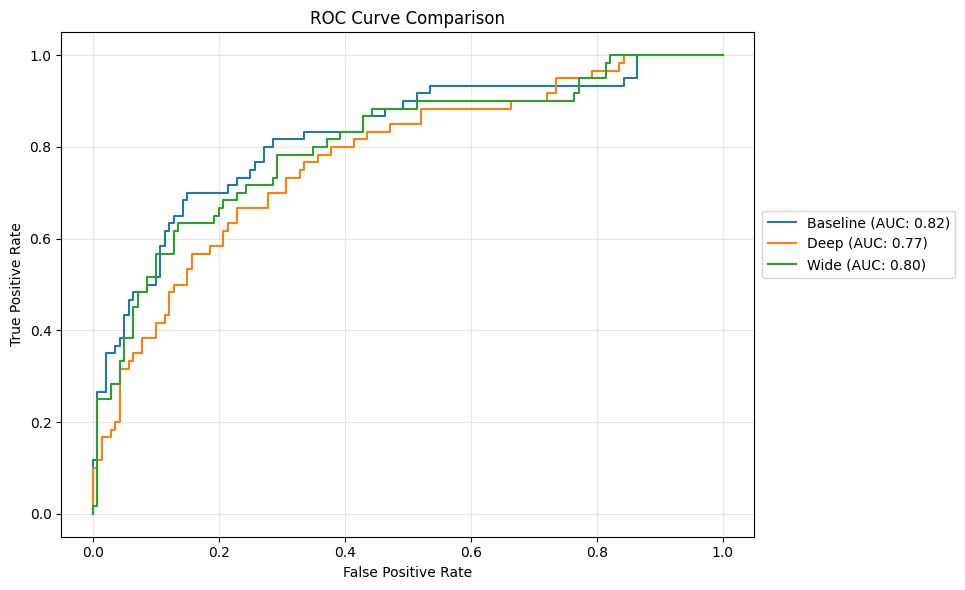

In [99]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {roc_auc_score(y_true, y_pred_proba):.2f})")

# Plot ROC curve comparison with enhancements
plt.figure(figsize=(10, 6))

# Plot ROC curves for all models
plot_roc_curve(y_test, y_pred_proba, "Baseline")
plot_roc_curve(y_test, y_pred_proba_deep, "Deep")
plot_roc_curve(y_test, y_pred_proba_wide, "Wide")

# Add title and labels
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add gridlines for readability
plt.grid(alpha=0.3)

# Move legend outside the plot
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.5))

plt.tight_layout()
plt.show()


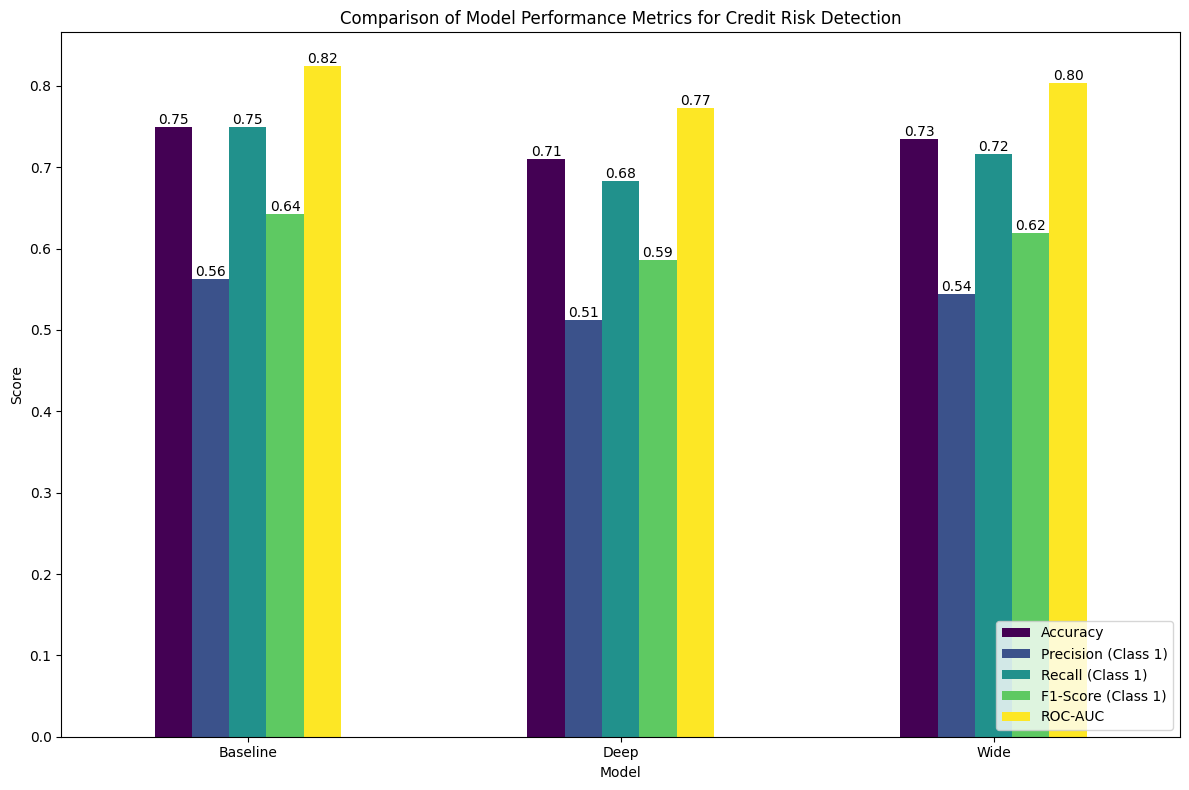

In [100]:
# Bar plot for metrics comparison
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8), colormap='viridis')

# Add labels and title
plt.title('Comparison of Model Performance Metrics for Credit Risk Detection')
plt.ylabel('Score')
plt.xticks(rotation=0)

# Annotate bars with metric values
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

# Moving the legend lower right
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


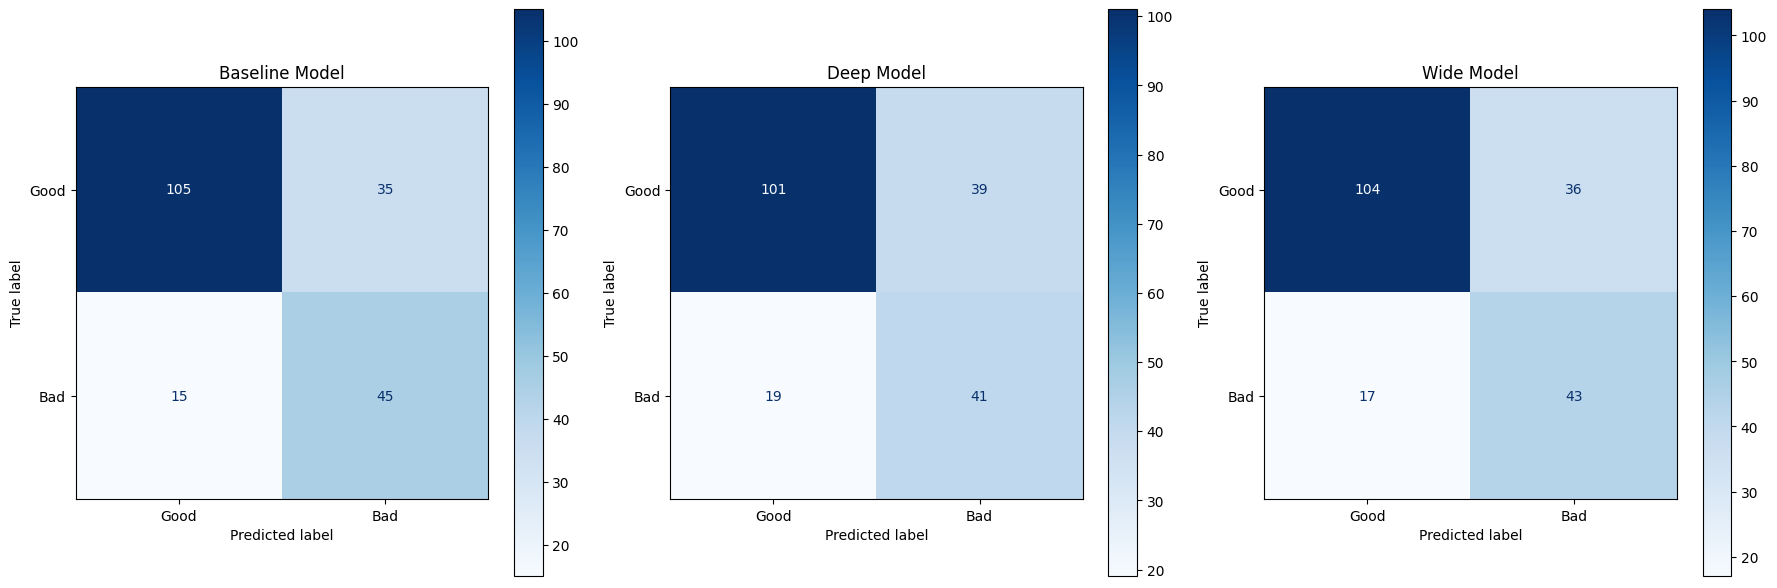

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Baseline Model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Good', 'Bad'], cmap='Blues', ax=axes[0])
axes[0].set_title("Baseline Model")

# Deep Model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_deep, display_labels=['Good', 'Bad'], cmap='Blues', ax=axes[1])
axes[1].set_title("Deep Model")

# Wide Model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_wide, display_labels=['Good', 'Bad'], cmap='Blues', ax=axes[2])
axes[2].set_title("Wide Model")

# Adjust layout for clarity
plt.tight_layout()
plt.show()
